Detecting the digits and storing them in files using opencv:

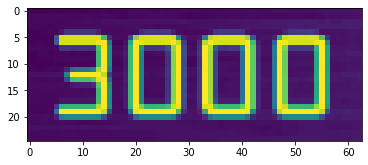

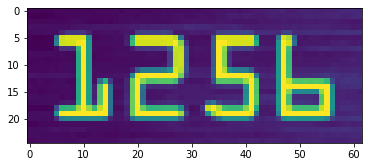

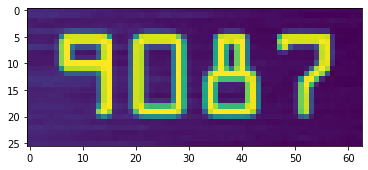

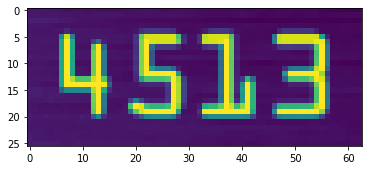

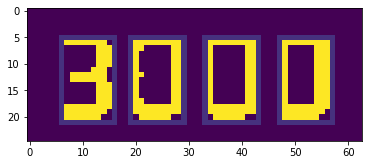

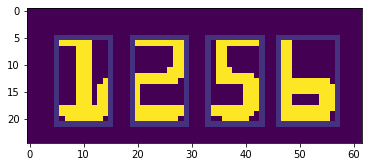

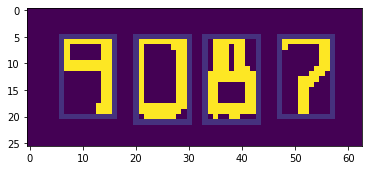

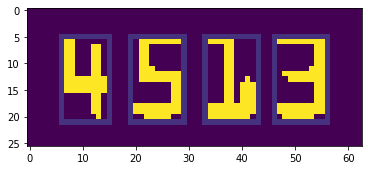

In [1]:
import cv2
import imutils
import argparse
import numpy as np
from imutils import contours
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import re
%matplotlib inline

rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
image = cv2.imread("Blue-Credit-Card-PNG-Free-Download.png")
image = imutils.resize(image, width=300)
plt.imshow(image , interpolation='nearest')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#it is useful in removing noise
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)

gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))

gradX = gradX.astype("uint8")
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []
for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    if ar > 2.5 and ar < 4.0:
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            locs.append((x, y, w, h))
locs = sorted(locs, key=lambda x:x[0])
output = []
from PIL import Image
digit_num=0
lst=[]
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    groupOutput = []
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    plt.imshow(group, interpolation='nearest')
    plt.show()
 
    im = Image.fromarray(group)
    im.save("group"+str(digit_num)+".png")
    lst.append("group"+str(digit_num)+".png")
    digit_num+=1

lst_digits_name=[]
for i in range(len(lst)):
    image = cv2.imread(lst[i])
    copy = image.copy()
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]
    
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if i==0:
        ROI_number = 1
    elif i==1:
        ROI_number = 5
    elif i==2:
        ROI_number =9
    else :
        ROI_number = 13
    
    for c in cnts[::-1]:
        x,y,w,h = cv2.boundingRect(c)
        ROI = image[y:y+h, x:x+w]
        cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
        lst_digits_name.append('ROI_{}.png'.format(ROI_number))
        cv2.rectangle(thresh,(x,y),(x+w,y+h),(36,255,12),0)
        ROI_number += 1
    plt.imshow(thresh, interpolation='nearest')
    plt.show()

using Cuda if available:

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


grouping the data into train, test and validation sets

In [17]:
os.chdir('data/Credit Card Number Dataset')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0,10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 20)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}',f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}',f'test/{i}')
os.chdir('../..')
os.getcwd()

train_path = 'data/Credit Card Number Dataset/train'
valid_path = 'data/Credit Card Number Dataset/valid'
test_path = 'data/Credit Card Number Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory = train_path, target_size = (224, 224), batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory = valid_path, target_size = (224, 224), batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory = test_path, target_size = (224, 224), batch_size = 10, shuffle = False)

Found 635 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


Defining, Tuning and training the model(MobileNet):

In [18]:
mobile = tf.keras.applications.mobilenet.MobileNet()

x = mobile.layers[-2].output
output = Dense(units = 10, activation = 'softmax')(x)

model = Model(inputs = mobile.input, outputs = output)

for layer in model.layers[:-23]:
    layer.trainable = False
    
model.compile(optimizer = Adam(learning_rate =  0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.fit(x=train_batches, validation_data = valid_batches, epochs = 39, verbose = 2)



Epoch 1/39
64/64 - 4s - loss: 2.6380 - accuracy: 0.4331 - val_loss: 4.0406 - val_accuracy: 0.4400 - 4s/epoch - 70ms/step
Epoch 2/39
64/64 - 2s - loss: 0.4340 - accuracy: 0.8614 - val_loss: 3.9771 - val_accuracy: 0.4350 - 2s/epoch - 35ms/step
Epoch 3/39
64/64 - 2s - loss: 0.2035 - accuracy: 0.9291 - val_loss: 1.7674 - val_accuracy: 0.6550 - 2s/epoch - 35ms/step
Epoch 4/39
64/64 - 2s - loss: 0.1215 - accuracy: 0.9559 - val_loss: 1.1370 - val_accuracy: 0.7100 - 2s/epoch - 38ms/step
Epoch 5/39
64/64 - 2s - loss: 0.0729 - accuracy: 0.9795 - val_loss: 0.9804 - val_accuracy: 0.7600 - 2s/epoch - 35ms/step
Epoch 6/39
64/64 - 2s - loss: 0.0556 - accuracy: 0.9874 - val_loss: 1.3083 - val_accuracy: 0.7350 - 2s/epoch - 38ms/step
Epoch 7/39
64/64 - 2s - loss: 0.0310 - accuracy: 0.9906 - val_loss: 0.9097 - val_accuracy: 0.7750 - 2s/epoch - 38ms/step
Epoch 8/39
64/64 - 3s - loss: 0.0453 - accuracy: 0.9874 - val_loss: 0.9514 - val_accuracy: 0.7750 - 3s/epoch - 44ms/step
Epoch 9/39
64/64 - 3s - loss: 0.

testing the model

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 1 0 1 0]
 [0 0 0 0 4 0 0 0 1 0]
 [0 0 0 0 1 3 1 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 1 0 4 0]
 [0 0 0 0 0 0 0 0 0 5]]


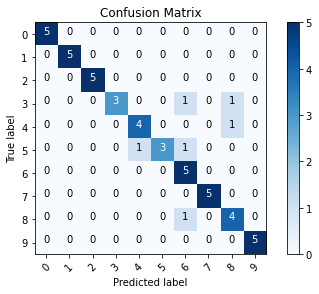

In [19]:
test_labels = test_batches.classes

predictions = model.predict(x=test_batches, verbose=0)

cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

test_batches.class_indices

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes = cm_plot_labels, title='Confusion Matrix')

using the model to predict credit card numbers

In [24]:
model.save('models/credit_card_predict_model.h5')
os.chdir('notebook')
from keras.preprocessing import image
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    return img_tensor

digits = []
predictions = []
digits = ['{}'.format(file) for file in glob.glob('ROI_*.png')]

def num_sort(test_string):
    return list(map(int, re.findall(r'\d+', test_string)))[0]

digits.sort(key=num_sort)
print(digits)
if __name__ == "__main__":
    for i in range(len(digits)):

        img_path = digits[i]
        new_image = load_image(img_path)
        pred = model.predict(new_image)
        predictions.append(pred)
    predict = np.array(predictions)
    print(predict.argmax(axis=-1))
    




['ROI_1.png', 'ROI_2.png', 'ROI_3.png', 'ROI_4.png', 'ROI_5.png', 'ROI_6.png', 'ROI_7.png', 'ROI_8.png', 'ROI_9.png', 'ROI_10.png', 'ROI_11.png', 'ROI_12.png', 'ROI_13.png', 'ROI_14.png', 'ROI_15.png', 'ROI_16.png']
[[3]
 [0]
 [0]
 [0]
 [6]
 [6]
 [5]
 [6]
 [7]
 [0]
 [6]
 [7]
 [6]
 [5]
 [6]
 [5]]
